In [1]:
import os 
os.chdir(r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics')

In [2]:
import geopandas as gpd
import pandas as pd

path = r'raw_data\sf_neighborhoods.geojson'
sfnhood = gpd.read_file(path)

path = r'raw_data\sf_quadrants.geojson'
sfquad = gpd.read_file(path)

In [3]:
path = r'static_data\metadata\sf_permit_metadata.xlsx'
sfp_meta = pd.read_excel(path)

new_col_names = {
    old.lower():new for old,new in sfp_meta[['Column Name','New Name']].values 
    if type(new) == str
}
keep_cols = sfp_meta.loc[sfp_meta['Keep']=='y', 'Column Name'].str.lower().to_list() + ['geometry']

In [4]:
import pandas as pd
import geopandas as gpd

path = r'raw_data\sf_planning_permits_20220321.geojson'
sfp_full = gpd.read_file(path)

In [5]:
prj_filt = sfp_full['record_type']=='PRJ'
sfp = sfp_full[prj_filt][keep_cols].copy()

sfp.columns = [
    new_col_names[c] if c in new_col_names.keys()
    else c
    for c in list(sfp)
]
unit_col = [c for c in list(sfp) if '#' in c]
sfp[unit_col] = sfp[unit_col].astype(float).astype(int)

#drop_i = [75836, 83452, 206137]
#sfp = sfp.drop(index=drop_i)

date_col = [c for c in list(sfp) if 'date' in c]
sfp[date_col] = sfp[date_col].apply(pd.to_datetime)

all_filt = sfp['#units_prop']>0
mr_filt = sfp['#units_prop_mr']>0
sfp = sfp[all_filt|mr_filt]

sfp = sfp[~sfp['geometry'].is_empty] 

date_close = '2015Q3'
sfp = sfp[sfp['date_close'].dt.to_period("Q")>=date_close]

date_open = '2007-01-01'
sfp = sfp[sfp['date_open']>date_open]

sfp = sfp.sjoin(sfnhood).drop(columns='index_right')

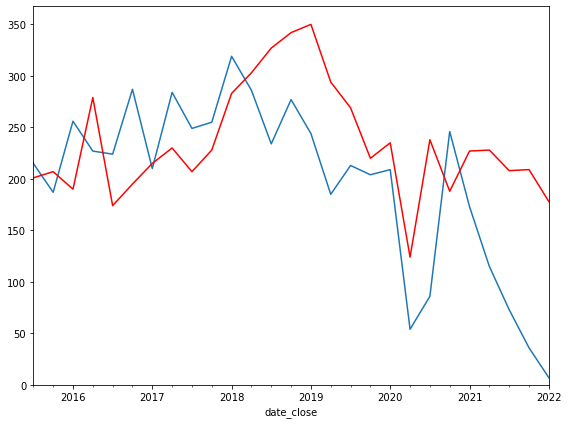

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

date_start = '2015Q3'

fig  = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
#ax2 = ax1.twinx()
#ax.set(facecolor = None)

def date_group(date_col, period = 'Q'):
    return sfp.sort_values(date_col).groupby(sfp[date_col].dt.to_period(period))['id'].count()

date_col = 'date_open'
date_group(date_col).plot(ax=ax, kind="line")
#date_group(date_col, period="Y").plot(ax=ax, color='black', kind="bar")

date_col = 'date_close'
date_group(date_col).plot(ax=ax, color='red', kind="line")

ax.set_xlim([date_start,None])
ax.set_ylim([0,None])

plt.show()

In [18]:
sfp

,id,status,name,#units,#units_mr,#units_aff,#units_exist,#units_exist_mr,#units_exist_aff,#units_prop,#units_prop_mr,#units_prop_aff,date_open,date_close,date_ent_apr,date_app_acc,geometry,nhood,date_openclose,length
722,2015-009705PRJ,Closed,10 CASHMERE ST,0,0,0,16,0,16,16,0,16,2015-07-29,2015-08-25,NaT,NaT,POINT (-122.38263 37.73600),Bayview Hunters Point,2015-07-292015-08-25,27
62084,2007.0168,Closed,227 West Point Road,401,295,106,267,0,267,668,295,373,2007-02-14,2016-05-09,NaT,2007-02-14,POINT (-122.37996 37.73603),Bayview Hunters Point,2007-02-142016-05-09,3372
62516,2007.0106,Closed,833-835 Jamestown Avenue,198,198,0,0,0,0,198,198,0,2007-12-14,2016-05-09,NaT,NaT,POINT (-122.39222 37.71717),Bayview Hunters Point,2007-12-142016-05-09,3069
69630,2008.1260,Withdrawn,47-49 CERES ST,0,0,0,2,2,0,2,2,0,2008-10-14,2015-11-10,NaT,2009-01-29,POINT (-122.39404 37.73018),Bayview Hunters Point,2008-10-142015-11-10,2583
74523,2011.0121,Withdrawn,339 TOCOLOMA AV,0,0,0,1,1,0,1,1,0,2011-02-10,2016-03-02,NaT,2011-02-10,POINT (-122.39816 37.71075),Bayview Hunters Point,2011-02-102016-03-02,1847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145632,2018-009269PRJ,Closed,890 EL CAMINO DEL MAR,0,0,0,1,1,0,1,1,0,2018-07-02,2019-06-19,2019-01-31,2018-07-03,POINT (-122.49362 37.78697),Lincoln Park,2018-07-022019-06-19,352
146318,2018-008269PRJ,Closed,880 EL CAMINO DEL MAR,0,0,0,1,1,0,1,1,0,2018-06-11,2019-02-11,NaT,NaT,POINT (-122.49345 37.78709),Lincoln Park,2018-06-112019-02-11,245
148288,2018-011026PRJ,Closed,2545 LYON ST,0,0,0,2,2,0,2,2,0,2018-08-10,2019-06-14,NaT,NaT,POINT (-122.44698 37.79453),Presidio,2018-08-102019-06-14,308
154235,2019-003593PRJ,Closed,2545 – 2547 Lyon Street,1,1,0,2,2,0,3,3,0,2019-03-18,2019-05-15,NaT,NaT,POINT (-122.44698 37.79453),Presidio,2019-03-182019-05-15,58


In [7]:
#sfp[sfp['date_open']>='2015-01-01'].count()
#sfp[sfp['date_open']<'2015-01-01'].count()

sfp['date_openclose'] = sfp['date_open'].astype(str) + sfp['date_close'].astype(str)

sfp['length'] = (sfp['date_close'] - sfp['date_open']).dt.days
#(sfp['length']/365).hist()

long_plot = sfp.dropna(subset=['date_open','date_close'])

#fig  = plt.figure(figsize = (8,6))
#ax = fig.add_subplot(111)

period = 'Q'
#ax.barh(
#    long_plot.date_open.dt.to_period(period), 
#    long_plot.date_close.dt.to_period(period), 
#    left=long_plot.date_open.dt.to_period(period))


In [14]:
a = sfp['date_app_acc'].dropna().count()
t = len(sfp)

a/t

unit_max = 100000
sjp_join = sfp[sfp['#units_prop']<unit_max].copy()

sfp_nhood = sjp_join.groupby('nhood')['id'].count().to_dict()
sfnhood['permit_count'] = sfnhood['nhood'].map(sfp_nhood).fillna(value=0).astype(int)


sfp_unit = sjp_join.groupby('nhood')['#units_prop'].sum().to_dict()
sfnhood['unit_prop_count'] = sfnhood['nhood'].map(sfp_unit).fillna(value=0)

sjp_join['unit_per_permit'] = sjp_join['#units_prop']/1
sfp_upp = sjp_join.groupby('nhood')['unit_per_permit'].median().to_dict()
sfnhood['unit_per_permit'] = sfnhood['nhood'].map(sfp_upp).fillna(value=0)

In [10]:
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase

class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})

def set_label(
    bins,
    zero = True,
    binder = '-'
    ):
    binder = ' {} '.format(binder)

    if zero == True:
        bins = [0] + bins

    bins = list(zip(bins[:-1],bins[1:]))

    def to_string(pair):
        paired = str(pair[0]) + binder + str(pair[1])
        return paired

    bins = [to_string(bin) for bin in bins]
    bins = [
        '0' if bin == '0' + binder + '0'
        else bin 
        for bin in bins
        ]
    return bins

def set_legend(leg, new_texts, location=2):
    
    leg._loc = location

    for lbl,new_text in zip(leg.get_texts(), new_texts):
        label_text = lbl.get_text()
        #lower = label_text.split()[0]
        #upper = label_text.split()[2]
        #new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
        lbl.set_text(new_text)

C:\Users\nelms\AppData\Local\Temp\ipykernel_11312\3268762778.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)
C:\Users\nelms\AppData\Local\Temp\ipykernel_11312\3268762778.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)


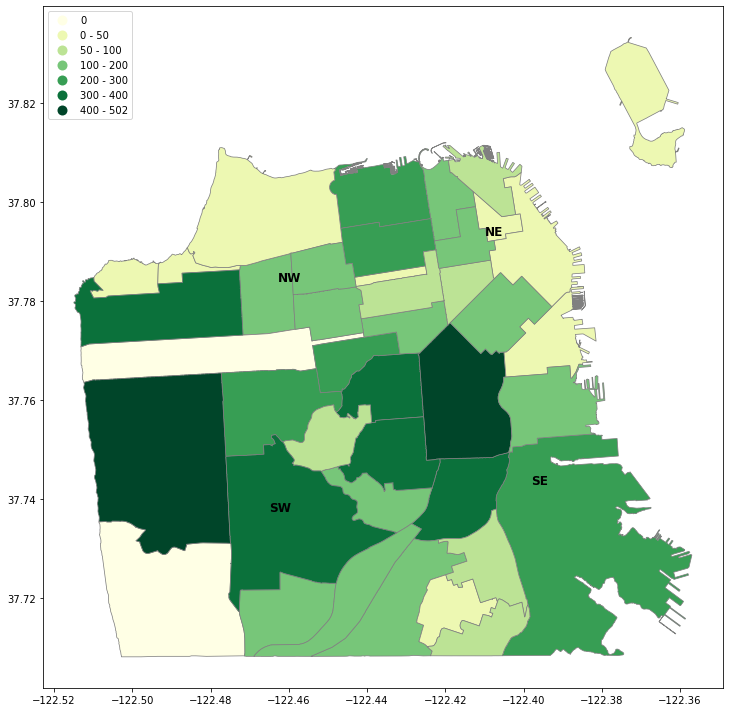

In [17]:
plot_col = 'permit_count'

map_bin = dict(bins=[0,50,100,200,300,400, sfnhood[plot_col].max()])

ax = sfnhood.plot(
    column=plot_col, 
    cmap='YlGn', 
    figsize=(40, 10), 
    scheme='User_Defined',
    classification_kwds=map_bin, k=len(map_bin)-1, 
    legend=True, linewidth=0.75, edgecolor='grey')

sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)

for x, y, label in sfquads:
    ax.annotate(
        label, xy=(x, y), xytext=(3, 3), 
        textcoords="offset points",
        fontsize='large',
        fontweight='bold'
        )

leg = ax.get_legend()
set_legend(leg, set_label(map_bin['bins']))

<AxesSubplot:>

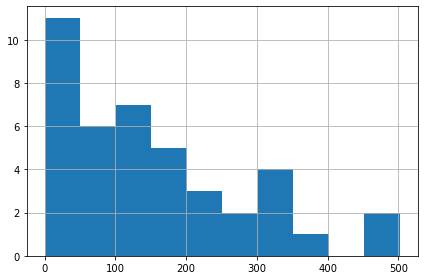

In [15]:
sfnhood['permit_count'].hist()

In [ ]:
from matplotlib.text import Text
from matplotlib.legend import Legend

handles = list(string.ascii_uppercase)[:N] 
labels = [f"Model Name {c}" for c in handles]

fig, ax = plt.subplots()
ax.scatter(x, y, s=100, c=colors, alpha=0.5)
for i, xy in enumerate(zip(x, y)):
    ax.annotate(handles[i], xy=xy)

ax.legend(handles=handles, labels=labels)

([], [])

In [ ]:
sfp.sort_values('#units_prop', ascending=False).head(30)

,id,type,status,name,#units,#units_mr,#units_aff,#units_exist,#units_exist_mr,#units_exist_aff,#units_prop,#units_prop_mr,#units_prop_aff,date_open,date_close,date_ent_apr,date_app_acc,geometry,nhood,unit_per_permit
71627,2010.0305,PRJ,Closed,Sunnydale HOPE SF Master Plan,915,0,915,785,0,785,1700,0,1700,2010-04-28,2021-12-03,2017-04-28,2010-04-28,POINT (-122.41959 37.71188),Visitacion Valley,1700.0
60310,2006.0422,PRJ,Closed,"EXECUTIVE PARK, HARNEY WAY",1600,1600,0,0,0,0,1600,1600,0,2006-03-22,2016-05-09,NaT,2006-03-22,POINT (-122.39258 37.71204),Bayview Hunters Point,1600.0
61427,2006.0829,PRJ,Closed,Hunters Point Shipyard Phase I Dev.,1600,1600,0,0,0,0,1600,1600,0,2006-07-07,2016-05-09,NaT,2006-07-07,POINT (-122.36739 37.72376),Bayview Hunters Point,1600.0
81494,2013.0208,PRJ,Closed,Seawall Lot 337/Pier 48 (Mission Rock Developm...,1500,0,0,0,0,0,1500,0,0,2013-02-22,2020-01-09,NaT,2013-06-04,POINT (-122.38614 37.77570),Mission Bay,1500.0
86257,2014-002541PRJ,PRJ,Withdrawn,700 Innes Avenue - India Basin,980,980,0,0,0,0,980,980,0,2014-12-09,2020-05-06,2019-08-05,2014-12-12,POINT (-122.37179 37.73284),Bayview Hunters Point,980.0
87630,2014-000203PRJ,PRJ,Under Review,655 04TH ST,957,957,0,3,3,0,960,960,0,2015-11-16,2019-07-10,2019-08-14,2016-04-26,POINT (-122.39494 37.77778),South of Market,960.0
42957,2000.1073,PRJ,Closed,201 Folsom St. (390 Main St),806,806,0,0,0,0,806,806,0,2000-10-11,2018-09-26,NaT,2000-10-11,POINT (-122.39185 37.78868),Financial District/South Beach,806.0
42783,2000.1090,PRJ,Closed,300 Spear ST,800,800,0,0,0,0,800,800,0,2000-10-17,2016-05-09,NaT,2000-10-17,POINT (-122.39097 37.78938),Financial District/South Beach,800.0
141063,2018-000948PRJ,PRJ,Closed,8 10TH ST,0,0,0,754,754,0,754,754,0,2018-01-16,2018-11-19,2018-09-21,2018-01-16,POINT (-122.41725 37.77583),South of Market,754.0
75392,2011.0409,PRJ,Closed,925 MISSION ST (5M),688,601,87,0,0,0,688,601,87,2011-04-27,2019-02-27,2016-02-09,2012-02-02,POINT (-122.40631 37.78173),South of Market,688.0


In [ ]:
path = r'static_data\sf_permit_acronyms.xlsx'
sfp_acr = pd.read_excel(path)
sfp_acr = {
    acr:name for acr,name in sfp_acr.set_index('Acronym')['Name'].to_dict().items()
    if type(acr) == str
}